# Admission prediction  - Using PCA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor,BaggingRegressor, StackingRegressor
from sklearn.svm import SVR,LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

### Loading the dataset

In [2]:
df = pd.read_csv('./Admission_Predict_Ver1.1.csv')
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


### Shape

In [3]:
df.shape

(500, 9)

### Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


### Description

In [5]:
df.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


### Dropping columns

In [6]:
df.drop(columns={'Serial No.','Research'},inplace=True)

### Renaming columns

In [7]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Chance of Admit '],
      dtype='object')

In [8]:
df.rename(columns={'GRE Score':'GRE_Score','TOEFL Score':'TOEFL_Score','University Rating':'University_Rating','Chance of Admit ':'Chance_of_Admit'},inplace=True)

### checking null percentage

In [9]:
df.isnull().mean()*100

GRE_Score            0.0
TOEFL_Score          0.0
University_Rating    0.0
SOP                  0.0
LOR                  0.0
CGPA                 0.0
Chance_of_Admit      0.0
dtype: float64

### checking duplicates

In [10]:
df.duplicated().sum()

0

## <center> EDA

### Univariate analysis

Here, all columns are numerical

In [11]:
len(df.columns)

7

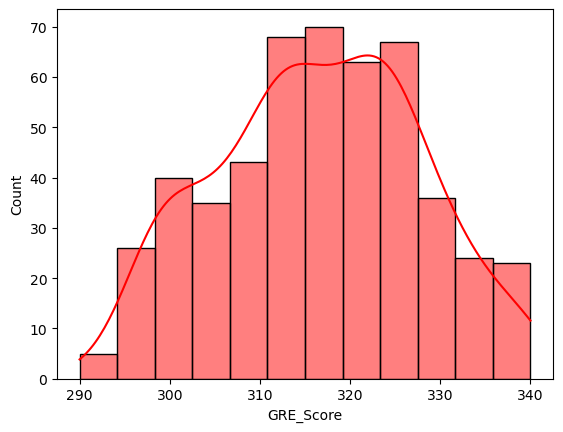

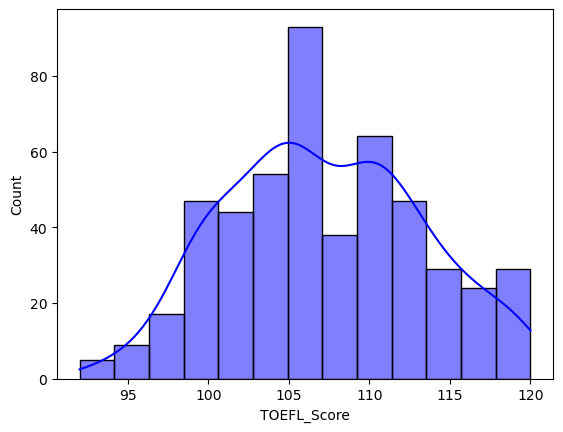

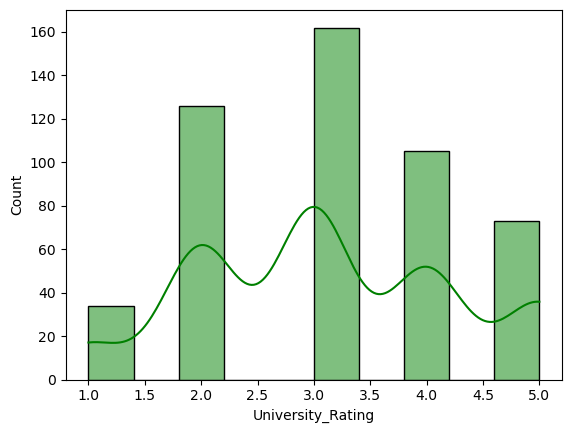

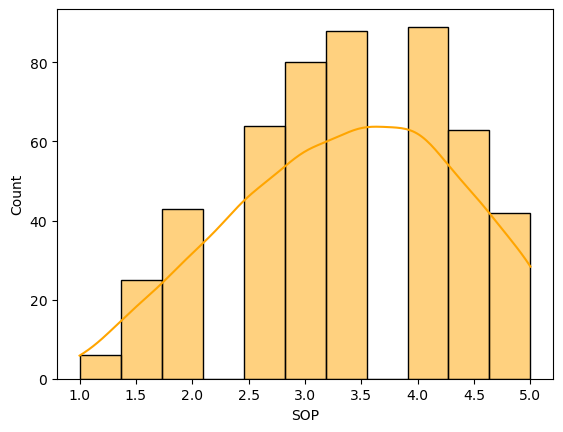

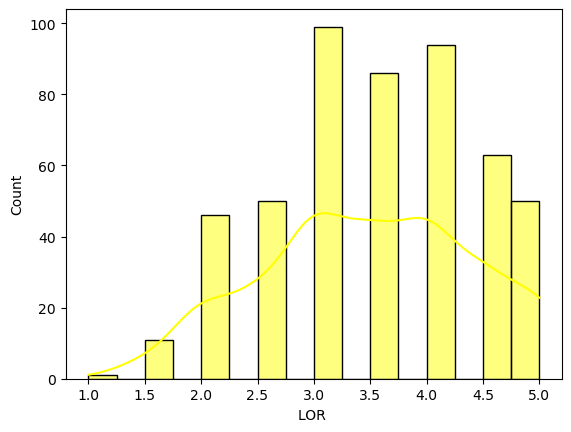

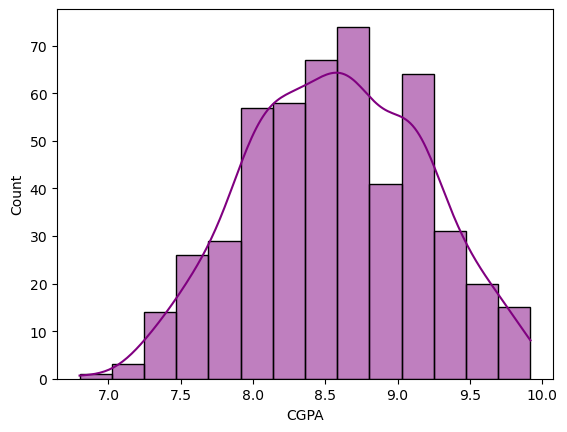

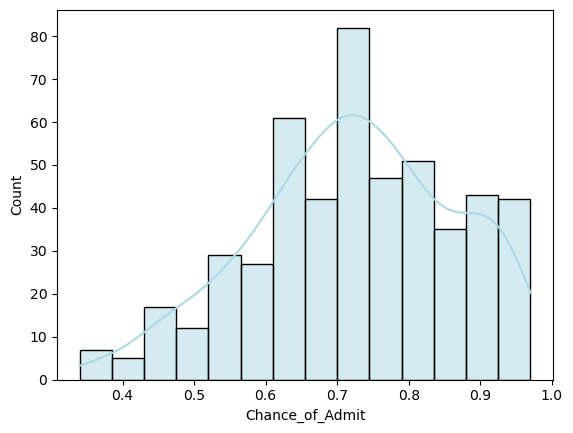

In [12]:
columns = ['Red', 'Blue', 'Green', 'Orange', 'Yellow', 'Purple', 'lightblue']
for i in range(len(df.columns)):
    sns.histplot(data=df, x=df.columns[i], kde=True, color=columns[i % len(columns)])
    plt.show()


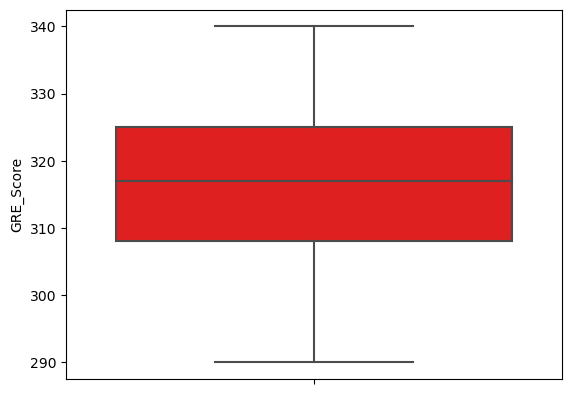

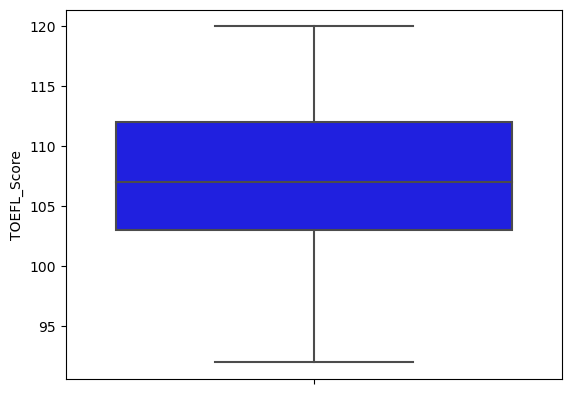

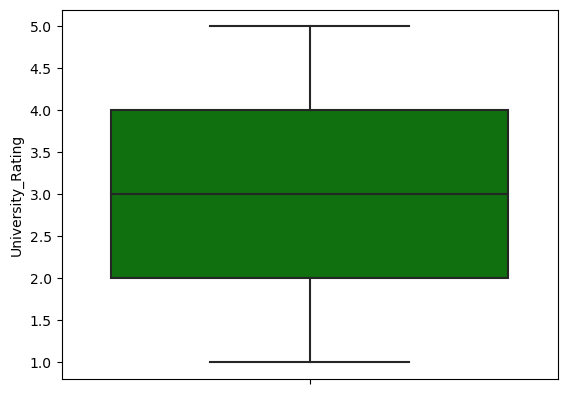

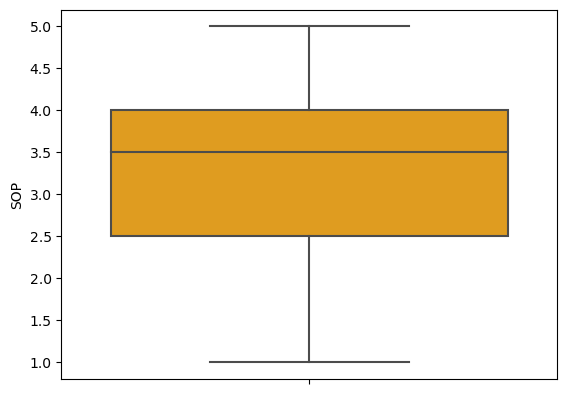

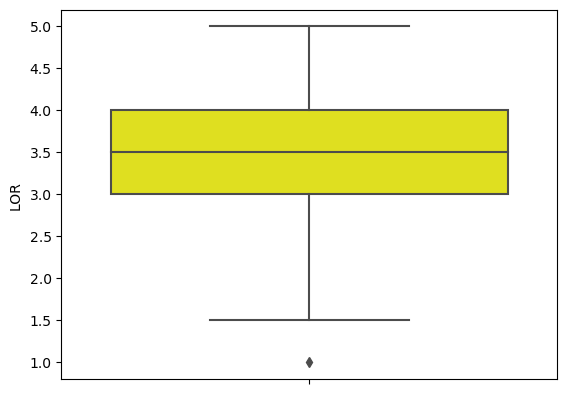

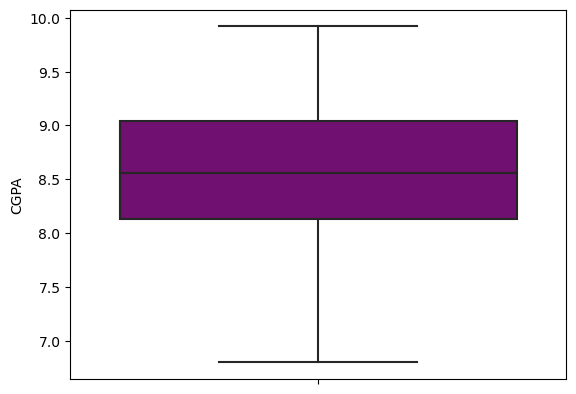

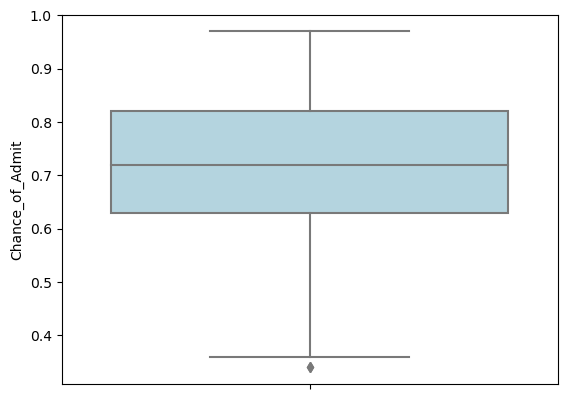

In [13]:
columns = ['Red', 'Blue', 'Green', 'Orange', 'Yellow', 'Purple', 'lightblue']
for i in range(len(df.columns)):
    sns.boxplot(data=df, y=df.columns[i],  color=columns[i % len(columns)])
    plt.show()

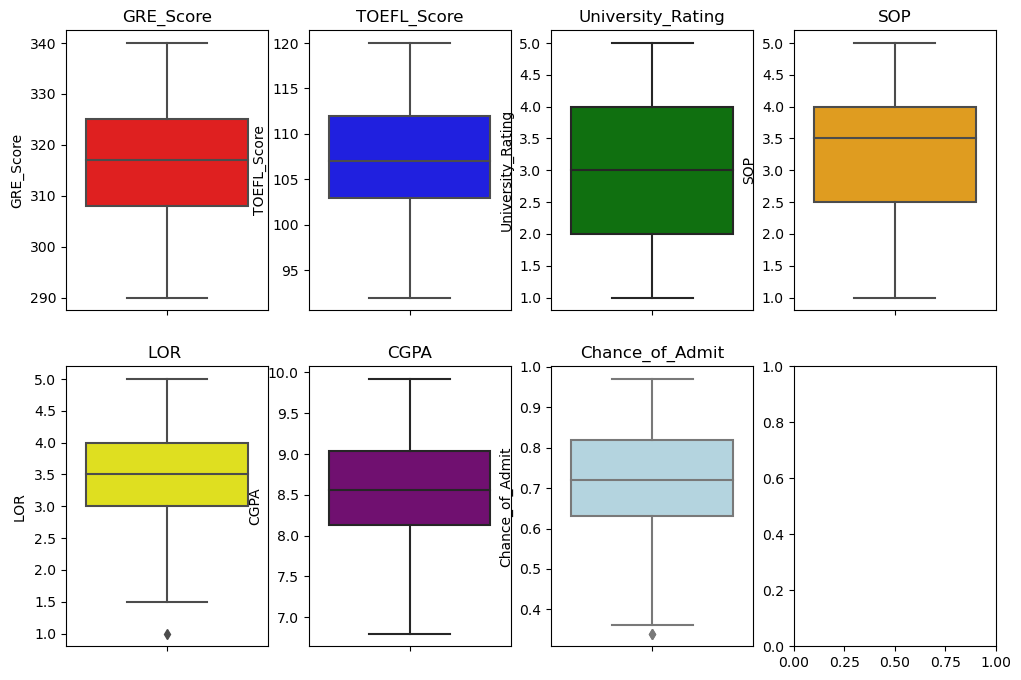

In [14]:
columns = ['Red', 'Blue', 'Green', 'Orange', 'Yellow', 'Purple', 'lightblue']
num_rows = 2
num_cols = 4

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

for i, col in enumerate(df.columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx][col_idx]
    sns.boxplot(data=df, y=col, color=columns[i % len(columns)], ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')


In [15]:
df.columns

Index(['GRE_Score', 'TOEFL_Score', 'University_Rating', 'SOP', 'LOR ', 'CGPA',
       'Chance_of_Admit'],
      dtype='object')

#### Checking  correlation of the chances of admit

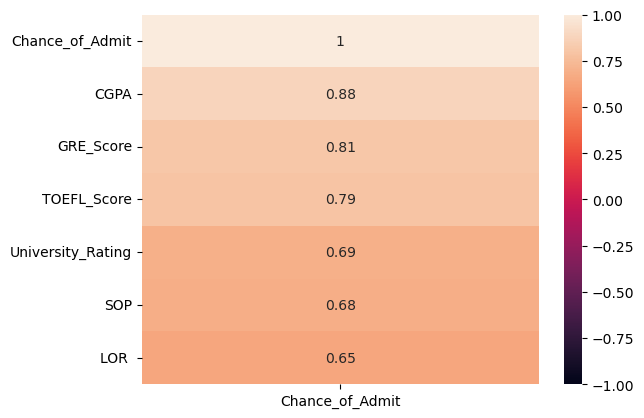

In [16]:
sns.heatmap(df.corr()[['Chance_of_Admit']].sort_values(by='Chance_of_Admit',ascending=False),vmin=-1,annot=True);

### Treating outliers

In [17]:
def oulier_limit(col):
    Q3,Q1 = np.nanpercentile(col,[75,25])
    IQR = Q3 - Q1
    UL = Q3 + 1.5*IQR
    LL = Q1 - 1.5*IQR
    return UL,LL

In [18]:
df.columns[1]

'TOEFL_Score'

In [19]:
for i in df.columns:
    UL,LL = oulier_limit(df[i])
    df[i] = np.where((df[i]>UL)| (df[i]<LL),np.nan,df[i])

##### Droping the null value created after the outlier treatment

In [20]:
df.dropna(inplace=True)

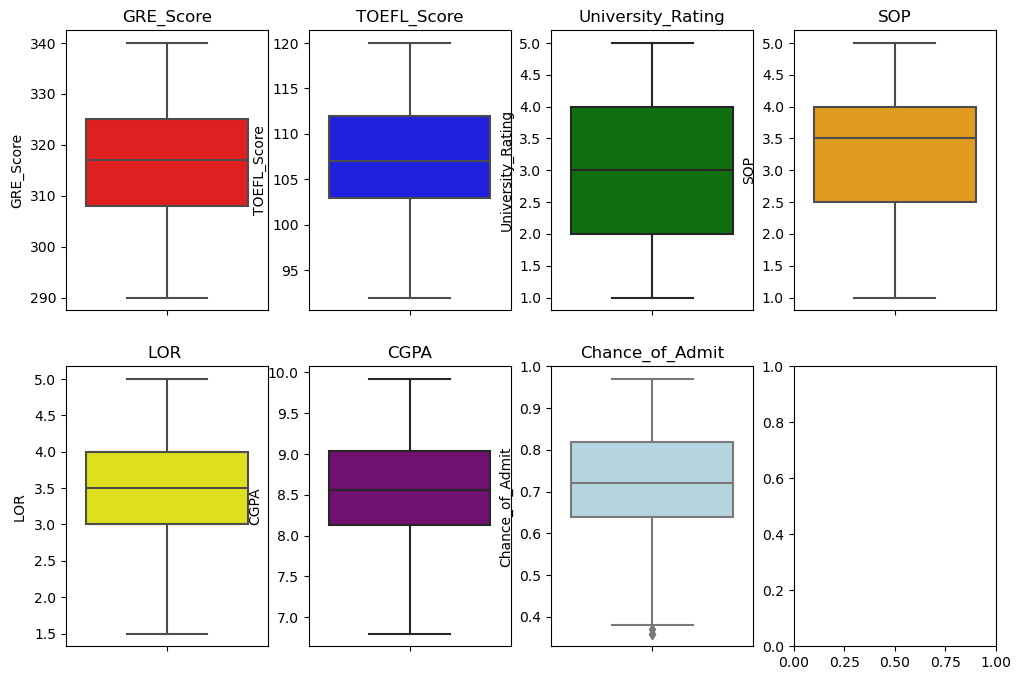

In [21]:
columns = ['Red', 'Blue', 'Green', 'Orange', 'Yellow', 'Purple', 'lightblue']
num_rows = 2
num_cols = 4

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 8))

for i, col in enumerate(df.columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    ax = axes[row_idx][col_idx]
    sns.boxplot(data=df, y=col, color=columns[i % len(columns)], ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')

In [22]:
x = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

#### Scaling the features

In [23]:
sc = StandardScaler()

In [24]:
x = sc.fit_transform(x)

### Fitting the featueres using PCA

In [25]:
pca_model = PCA().fit(x)

###### percentage  weight of feautures

In [26]:
pca_model.explained_variance_ratio_

array([0.72856616, 0.10624822, 0.06429176, 0.04415567, 0.03077169,
       0.0259665 ])

In [27]:
pca_model.explained_variance_ratio_.cumsum()

array([0.72856616, 0.83481439, 0.89910614, 0.94326181, 0.9740335 ,
       1.        ])

In [28]:
pca_model.singular_values_

array([46.61098901, 17.79978095, 13.84622769, 11.47485052,  9.5792054 ,
        8.79955168])

### Scree Plot

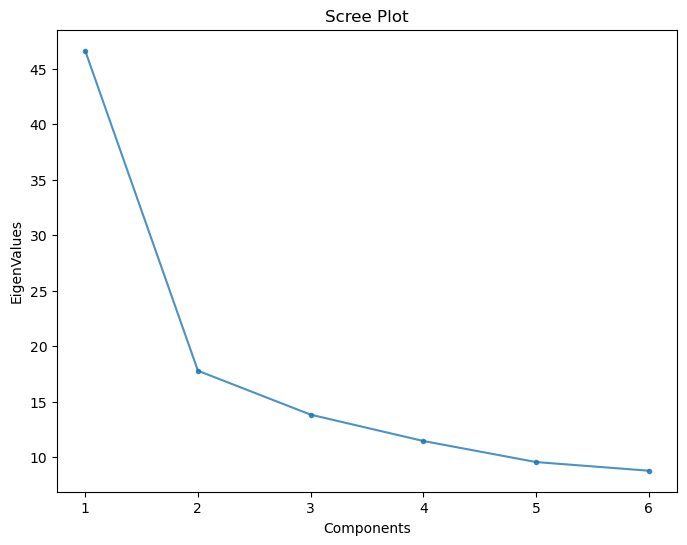

In [29]:
fig = plt.figure(figsize=(8,6))
plt.plot(range(1,len(pca_model.singular_values_)+1),pca_model.singular_values_,
         alpha=0.8,marker='.')
y_label = plt.ylabel('EigenValues')
x_label = plt.xlabel('Components')
plt.title('Scree Plot')
plt.show()

### Percentage of variance explained by component

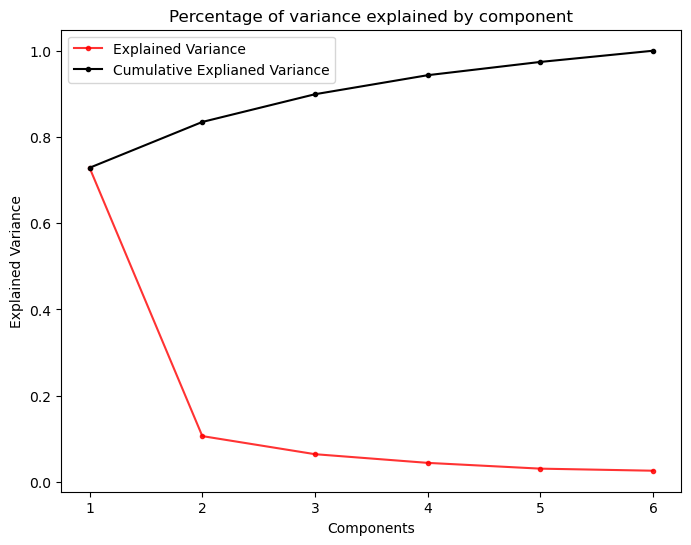

In [30]:
fig = plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca_model.explained_variance_ratio_)+1), pca_model.explained_variance_ratio_,
         marker = '.', alpha = 0.8, label = 'Explained Variance', color = 'red')
y_label = plt.ylabel('Explained Variance')
x_label = plt.xlabel('Components')
plt.plot(range(1, len(pca_model.explained_variance_ratio_)+1), pca_model.explained_variance_ratio_.cumsum(),
         marker = '.', label = 'Cumulative Explianed Variance', color = 'black')
plt.legend()
plt.title("Percentage of variance explained by component")
plt.show()

In [31]:
pca_x = PCA(n_components=4).fit_transform(x)

In [32]:
pca_x.shape

(497, 4)

### Splitting the data into training and testing sets

In [33]:
x_train,x_test,y_train,y_test = train_test_split(pca_x,y,test_size = 0.2, random_state= 46,shuffle=True)

### model building

In [34]:
models = {
    'LinearRegression':LinearRegression(),
    'Ridge': Ridge(random_state=100),
    'Lasso': Lasso(random_state=100),
    'LinearSVR': LinearSVR(random_state=100),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=100),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=100),
    'AdaBoostRegressor': AdaBoostRegressor(random_state=100),
    'RandomForestRegressor': RandomForestRegressor(random_state=100)
}

In [35]:
for name,model in models.items():
    model.fit(x_train,y_train)
    print('model trained with {}'.format(name))
    training_score = model.score(x_train,y_train)*100
    testing_score = model.score(x_test,y_test)*100
    score = r2_score(y_test,model.predict(x_test))*100
    mae = mean_absolute_error(y_test,model.predict(x_test))
    mse = mean_squared_error(y_test,model.predict(x_test))
    rmse = np.sqrt(mse)
    print('r2_score:',score)
    print('training_score: ',training_score)
    print('testing_score: ',testing_score)
    print('mae: ',mae)
    print('mse: ',mse)
    print('rmse_test:',rmse)
    print('*'*55)

model trained with LinearRegression
r2_score: 81.14308448919147
training_score:  79.53006989473576
testing_score:  81.14308448919147
mae:  0.03958763443121078
mse:  0.002724213327249283
rmse_test: 0.0521939970422776
*******************************************************
model trained with Ridge
r2_score: 81.1546202840015
training_score:  79.52998482791133
testing_score:  81.1546202840015
mae:  0.0395925996813851
mse:  0.0027225467786589842
rmse_test: 0.05217802965481721
*******************************************************
model trained with Lasso
r2_score: -0.6799072993108446
training_score:  0.0
testing_score:  -0.6799072993108446
mae:  0.09707556675062973
mse:  0.014544984575753919
rmse_test: 0.12060258942391709
*******************************************************
model trained with LinearSVR
r2_score: 81.61651825252768
training_score:  78.79087485638294
testing_score:  81.61651825252768
mae:  0.03847155342576427
mse:  0.0026558174877011316
rmse_test: 0.05153462416377102
*****

###### Choosing the best model
We can see that "LinearRegression" is having the best metrics.

### Model building

###### Initialising the model

In [36]:
model1 = LinearRegression()

###### Fitting the model with training data

In [37]:
model1.fit(x_train,y_train)

LinearRegression()

###### Predicting using the test data

In [38]:
y_pred = model1.predict(x_test)

##### Evaluating the accuracy

In [39]:
r2_score(y_test,y_pred)

0.8114308448919146

### Training accuracy

In [40]:
model1.score(x_train,y_train)

0.7953006989473577

### Testing accuracy¶

In [41]:
model1.score(x_test,y_test)

0.8114308448919146

##### MAE

In [42]:
mean_absolute_error(y_test,y_pred)

0.03958763443121078

##### MSE

In [43]:
mean_squared_error(y_test,y_pred)

0.002724213327249283

##### Root Mean Squared Error

In [44]:
np.sqrt(mean_squared_error(y_test,y_pred))

0.0521939970422776

#### Creating a dataframe with y_test and y_pred

In [45]:
OUTPUT = pd.DataFrame(zip(y_test,y_pred),columns=['ACTUAL','PREDICTION'])
OUTPUT.head()

,ACTUAL,PREDICTION
0,0.79,0.727625
1,0.42,0.538297
2,0.76,0.667408
3,0.65,0.717336
4,0.80,0.791628


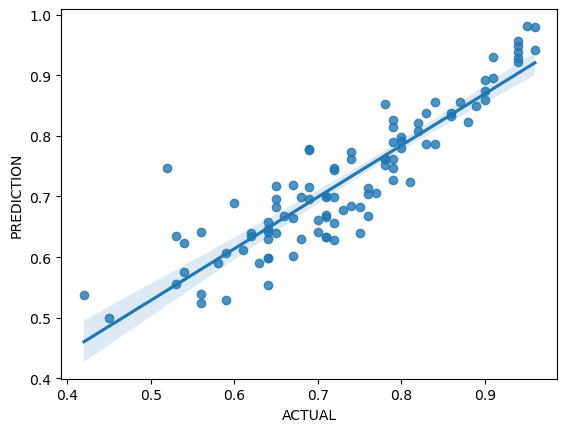

In [46]:
sns.regplot(data=OUTPUT, x = 'ACTUAL',y='PREDICTION');

### Error ploting

In [47]:
OUTPUT['ERROR'] = OUTPUT.ACTUAL- OUTPUT.PREDICTION

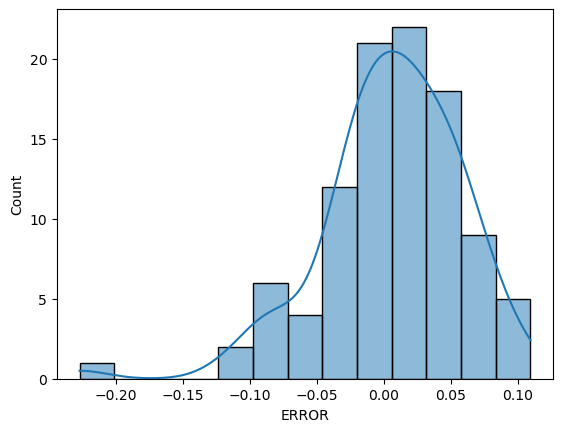

In [48]:
sns.histplot(data=OUTPUT, x= 'ERROR', kde=True)
plt.show()